In [2]:
import torch
import torch.nn.modules as nn
from torch.utils.data import Subset
from torch.optim import Adam
import torchvision
from   torchvision import transforms

import numpy as np
import shap
import matplotlib.pyplot as plt

In [2]:
image_path = './'

In [3]:
celeba_train_dataset = torchvision.datasets.CelebA(image_path, split='train', target_type='attr', download=True)  
celeba_valid_dataset = torchvision.datasets.CelebA(image_path, split='valid', target_type='attr', download=True)  
celeba_test_dataset  = torchvision.datasets.CelebA(image_path, split='test' , target_type='attr', download=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [4]:
print('Train set:', len(celeba_train_dataset))
print('Validation set:', len(celeba_valid_dataset))
print('Test set:', len(celeba_test_dataset))

Train set: 162770
Validation set: 19867
Test set: 19962


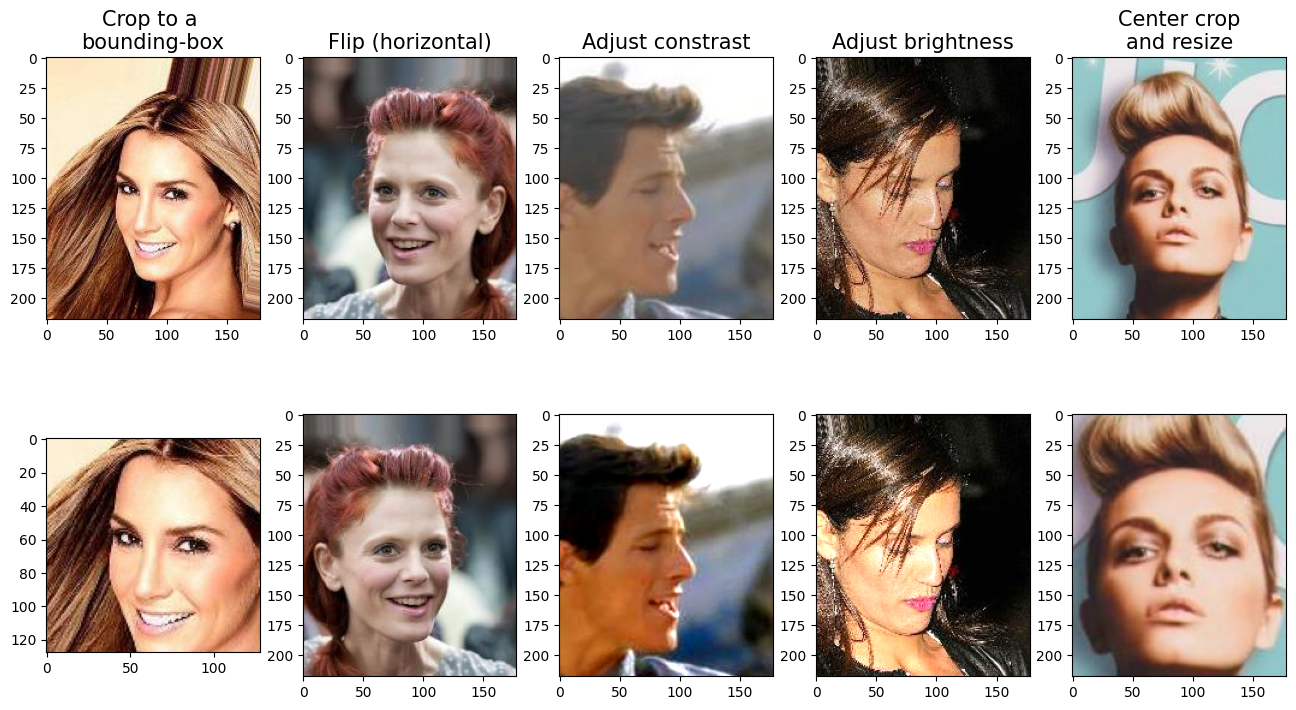

In [5]:
## take 5 examples

fig = plt.figure(figsize=(16, 8.5))

## Column 1: cropping to a bounding-box
ax = fig.add_subplot(2, 5, 1)
img, attr = celeba_train_dataset[0]
ax.set_title('Crop to a \nbounding-box', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 6)
img_cropped = transforms.functional.crop(img, 50, 20, 128, 128)
ax.imshow(img_cropped)

## Column 2: flipping (horizontally)
ax = fig.add_subplot(2, 5, 2)
img, attr = celeba_train_dataset[1]
ax.set_title('Flip (horizontal)', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 7)
img_flipped = transforms.functional.hflip(img)
ax.imshow(img_flipped)

## Column 3: adjust contrast
ax = fig.add_subplot(2, 5, 3)
img, attr = celeba_train_dataset[2]
ax.set_title('Adjust constrast', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 8)
img_adj_contrast = transforms.functional.adjust_contrast(img, contrast_factor=2)
ax.imshow(img_adj_contrast)

## Column 4: adjust brightness
ax = fig.add_subplot(2, 5, 4)
img, attr = celeba_train_dataset[3]
ax.set_title('Adjust brightness', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 9)
img_adj_brightness = transforms.functional.adjust_brightness(img, brightness_factor=1.3)
ax.imshow(img_adj_brightness)

## Column 5: cropping from image center 
ax = fig.add_subplot(2, 5, 5)
img, attr = celeba_train_dataset[4]
ax.set_title('Center crop\nand resize', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 10)
img_center_crop = transforms.functional.center_crop(img, [0.7*218, 0.7*178])
img_resized = transforms.functional.resize(img_center_crop, size=(218, 178))
ax.imshow(img_resized)
 
# plt.savefig('figures/14_14.png', dpi=300)
plt.show()

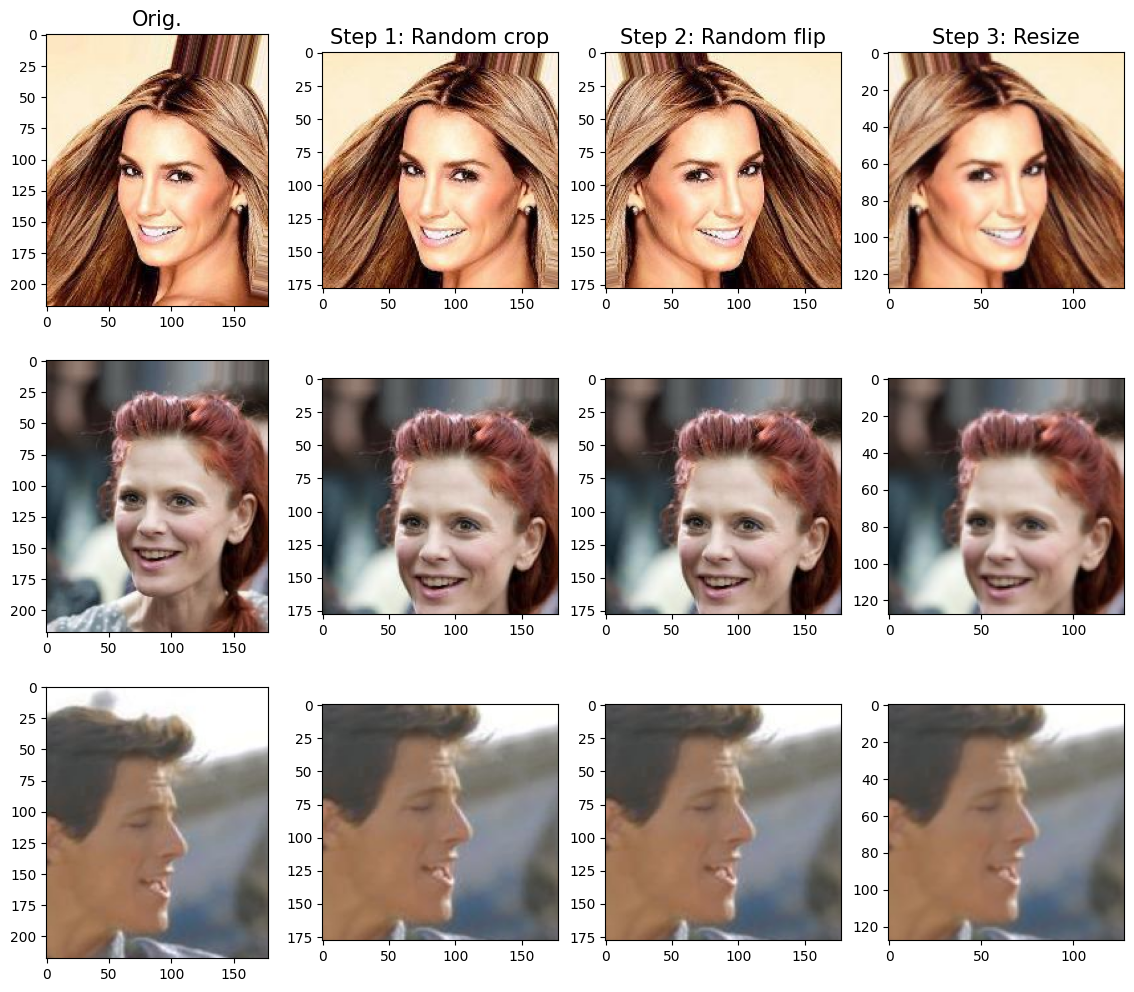

In [6]:
torch.manual_seed(1)

fig = plt.figure(figsize=(14, 12))

for i, (img, attr) in enumerate(celeba_train_dataset):
    ax = fig.add_subplot(3, 4, i*4+1)
    ax.imshow(img)
    if i == 0:
        ax.set_title('Orig.', size=15)
        
    ax = fig.add_subplot(3, 4, i*4+2)
    img_transform = transforms.Compose([transforms.RandomCrop([178, 178])])
    img_cropped = img_transform(img)
    ax.imshow(img_cropped)
    if i == 0:
        ax.set_title('Step 1: Random crop', size=15)

    ax = fig.add_subplot(3, 4, i*4+3)
    img_transform = transforms.Compose([transforms.RandomHorizontalFlip()])
    img_flip = img_transform(img_cropped)
    ax.imshow(img_flip)
    if i == 0:
        ax.set_title('Step 2: Random flip', size=15)

    ax = fig.add_subplot(3, 4, i*4+4)
    img_resized = transforms.functional.resize(img_flip, size=(128, 128))
    ax.imshow(img_resized)
    if i == 0:
        ax.set_title('Step 3: Resize', size=15)
    
    if i == 2:
        break
        
# plt.savefig('figures/14_15.png', dpi=300)
plt.show()

In [7]:
get_smile = lambda attr: attr[31]
 
transform_train = transforms.Compose([
    transforms.RandomCrop([178, 178]),
    transforms.RandomHorizontalFlip(),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])

transform = transforms.Compose([
    transforms.CenterCrop([178, 178]),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])

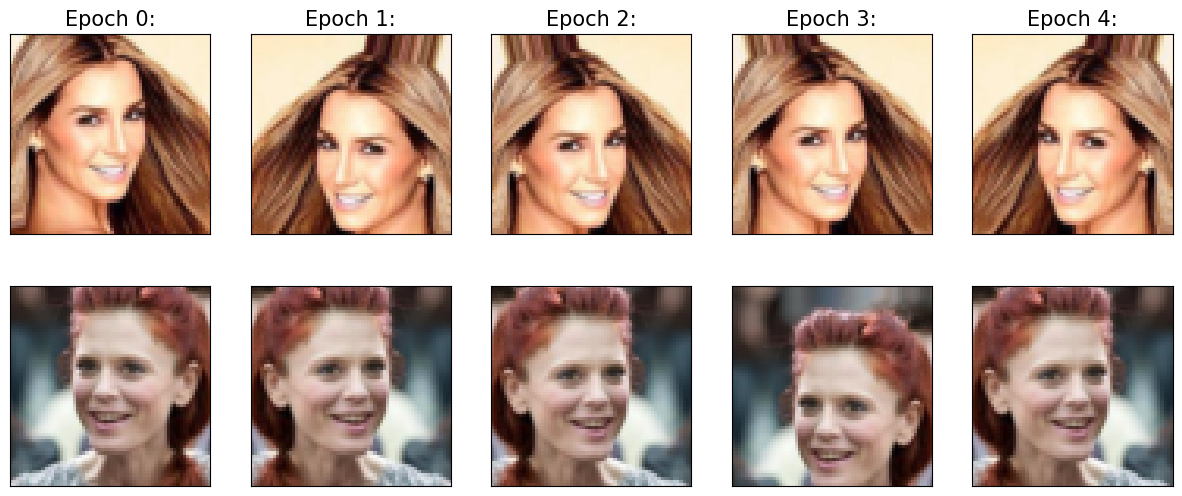

In [8]:
from torch.utils.data import DataLoader

celeba_train_dataset = torchvision.datasets.CelebA(image_path, 
                                                   split='train', 
                                                   target_type='attr', 
                                                   download=False, 
                                                   transform=transform_train,
                                                   target_transform=get_smile)

torch.manual_seed(1)
data_loader = DataLoader(celeba_train_dataset, batch_size=2)

fig = plt.figure(figsize=(15, 6))

num_epochs = 5
for j in range(num_epochs):
    img_batch, label_batch = next(iter(data_loader))
    img = img_batch[0]
    ax = fig.add_subplot(2, 5, j + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Epoch {j}:', size=15)
    ax.imshow(img.permute(1, 2, 0))

    img = img_batch[1]
    ax = fig.add_subplot(2, 5, j + 6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img.permute(1, 2, 0))
      
plt.show()

In [9]:

celeba_valid_dataset = torchvision.datasets.CelebA(
    image_path, split="valid",
    target_type="attr", download=False,
    transform=transform, target_transform=get_smile
)

celeba_test_dataset = torchvision.datasets.CelebA(
    image_path, split="test",
    target_type="attr", download=False,
    transform=transform, target_transform=get_smile
)

In [10]:
celeba_train_dataset = Subset(celeba_train_dataset,
                              torch.arange(16000))

celeba_valid_dataset = Subset(celeba_valid_dataset,
                              torch.arange(16000))

print('Train set:', len(celeba_train_dataset))
print('Train set:', len(celeba_valid_dataset))

Train set: 16000
Train set: 16000


In [11]:
batch_size = 32
torch.manual_seed(1)

train_dl = DataLoader(celeba_train_dataset,
                      batch_size, shuffle=True)

test_dl  = DataLoader(celeba_test_dataset,
                     batch_size, shuffle=False)

valid_dl = DataLoader(celeba_valid_dataset, 
                       batch_size, shuffle=False)

In [12]:
import torch.nn as nn

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.5)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.5)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=8),
            nn.Flatten()         
        )

        self.classifier = nn.Sequential(
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.classifier(x)
        return x


In [13]:
x = torch.ones((4, 3, 64, 64))
model = Model()
model(x).shape

torch.Size([4, 1])

In [14]:
model

Model(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=8, stride=8, padding=0)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
    

In [15]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [7]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [8]:
torch.cuda.is_available()


False

In [17]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()
        loss_hist_train[epoch]     /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch.float())
                loss_hist_train[epoch] += loss.item() * y_batch.size(0)
                is_correct = ((pred>=0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
            loss_hist_valid[epoch] /= len(valid_dl.dataset)
            accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: ',  
            f'{accuracy_hist_train[epoch]:.4f} val_accuracy: ',
            f'{accuracy_hist_valid[epoch]:.4f}')
            
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [18]:
num_epochs = 5
#hist = train(model, num_epochs, train_dl, valid_dl)

In [19]:
def train(model, num_epochs, train_dl, valid_dl, device):
    # Modeli CUDA'ya taşı
    model = model.to(device)

    # Optimizer'ı model GPU'ya taşındıktan sonra tekrar tanımla
    optimizer = torch.optim.Adam(model.parameters())

    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            # Verileri CUDA'ya taşı
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch.float())  # loss hesaplanırken de veriler GPU'da olmalı
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_correct = ((pred >= 0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().item()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                # Verileri CUDA'ya taşı
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)

                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch.float())

                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct = ((pred >= 0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().item()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid


In [20]:
num_epochs = 15
hist = train(model, num_epochs, train_dl, valid_dl, device)

Epoch 1 accuracy: 0.5086 val_accuracy: 0.5159
Epoch 2 accuracy: 0.5421 val_accuracy: 0.5855
Epoch 3 accuracy: 0.5813 val_accuracy: 0.6401
Epoch 4 accuracy: 0.6216 val_accuracy: 0.6619
Epoch 5 accuracy: 0.6494 val_accuracy: 0.6799
Epoch 6 accuracy: 0.6666 val_accuracy: 0.7206
Epoch 7 accuracy: 0.6981 val_accuracy: 0.7262
Epoch 8 accuracy: 0.7249 val_accuracy: 0.7694
Epoch 9 accuracy: 0.7391 val_accuracy: 0.7874
Epoch 10 accuracy: 0.7602 val_accuracy: 0.8007
Epoch 11 accuracy: 0.7847 val_accuracy: 0.8222
Epoch 12 accuracy: 0.7981 val_accuracy: 0.8538
Epoch 13 accuracy: 0.8129 val_accuracy: 0.8580
Epoch 14 accuracy: 0.8279 val_accuracy: 0.8698
Epoch 15 accuracy: 0.8296 val_accuracy: 0.8620


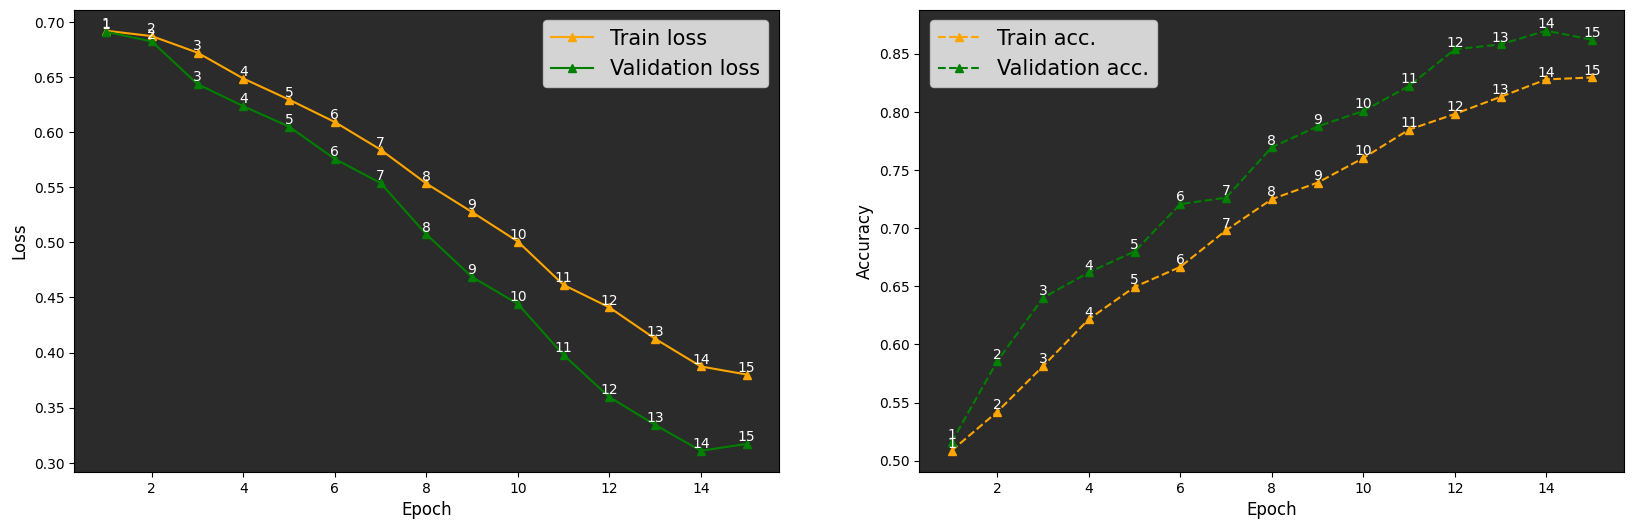

In [21]:

x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(20, 6))

ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-^', label='Train loss', color='orange') 
ax.plot(x_arr, hist[1], '-^', label='Validation loss', color='green') 
ax.legend(fontsize=15)
ax.set_ylabel('Loss', size=12)
ax.set_xlabel('Epoch', size=12)
ax.set_facecolor('#2b2b2b')  

for i, value in enumerate(hist[0]):
    ax.text(x_arr[i], value, str(i + 1), ha='center', va='bottom', fontsize=10, color='white')

for i, value in enumerate(hist[1]):
    ax.text(x_arr[i], value, str(i + 1), ha='center', va='bottom', fontsize=10, color='white')

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '--^', label='Train acc.', color='orange')  
ax.plot(x_arr, hist[3], '--^', label='Validation acc.', color='green')  
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=12)
ax.set_ylabel('Accuracy', size=12)
ax.set_facecolor('#2b2b2b')  

for i, value in enumerate(hist[2]):
    ax.text(x_arr[i], value, str(i + 1), ha='center', va='bottom', fontsize=10, color='white')

for i, value in enumerate(hist[3]):
    ax.text(x_arr[i], value, str(i + 1), ha='center', va='bottom', fontsize=10, color='white')

plt.show()

In [22]:
def test(model, test_dl, device):
    accuracy_test = 0
    model = model.to(device)

    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in test_dl:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            pred = model(x_batch)[:, 0]
            is_correct = ((pred >= 0.5).float() == y_batch).float()
            accuracy_test += is_correct.sum()
        
        accuracy_test /= len(test_dl.dataset)
    print(f'Test Accuracy : {accuracy_test:.4f}')
    
    

In [ ]:
test_model = test(model, test_dl, device)

In [121]:
def plot_face(model, test_dl, device):
    model.eval()
    for x_batch, y_batch in test_dl:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

    pred = model(x_batch)[:, 0] * 100

    fig = plt.figure(figsize=(15, 7))
    x_batch = x_batch.cpu().numpy()

    for j in range(10, 20):
        ax = fig.add_subplot(2, 5, j - 10 + 1)
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(x_batch[j].transpose(1, 2, 0))  # [C, H, W] -> [H, W, C]

        if y_batch[j] == 1:
            label = 'Smile'
        else:
            label = 'Not Smile'
        ax.text(0.5, -0.15, f'GT: {label:s}\nPr(Smile)={pred[j]:.0f}%', size=16, horizontalalignment='center',
                verticalalignment='center', transform=ax.transAxes)

    plt.show()

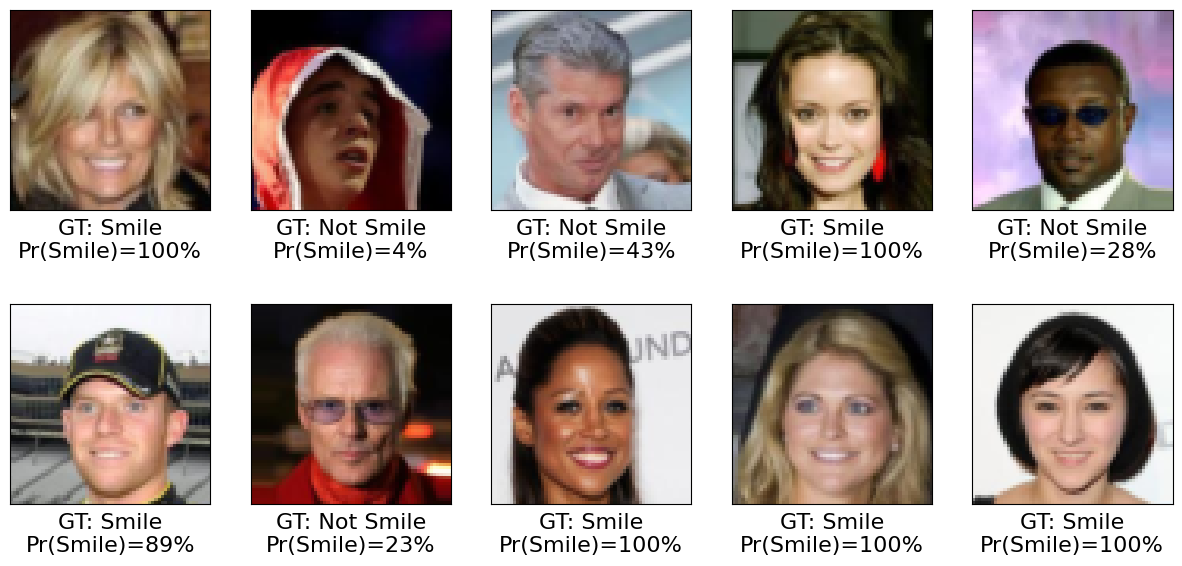

In [122]:
plot_face(model, test_dl, device)

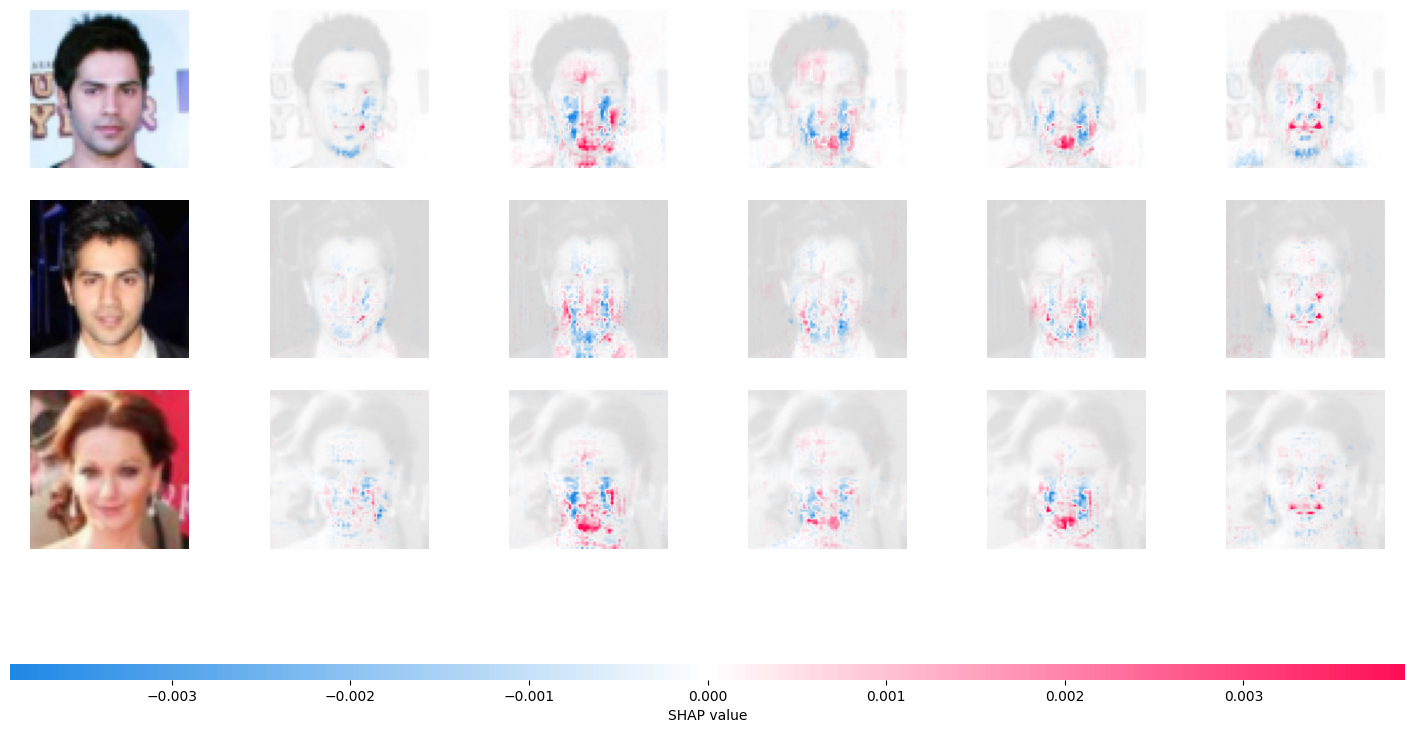

In [111]:
batch = next(iter(train_dl))
images, _ = batch 


background = images[:1500].to(device)
test_images = images[155:165].to(device)  


if test_images.size(0) < 32:
    remaining_count = 32 - test_images.size(0)
    additional_images = next(iter(test_dl))[0][:remaining_count].to(device)  
    test_images = torch.cat((test_images, additional_images), dim=0)  # Var olan görüntüleri ekle

# Test görüntülerinin boyutunu kontrol et
#print(test_images.size())  # Bu şimdi torch.Size([32, 3, 64, 64]) olmalı

model = model.to(device)
background = background.to(device)

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images[5:10])

shap_numpy = [s for s in shap_values]  
test_numpy = test_images[5:10].cpu().numpy() 

shap_numpy = [np.transpose(s, (0, 1, 2, 3)) for s in shap_numpy]  # [N, C, H, W] -> [N, H, W, C]
test_numpy = np.transpose(test_numpy, (0, 2, 3, 1))               # [N, C, H, W] -> [N, H, W, C]

num_images_to_plot = 3
shap_numpy = [s[:num_images_to_plot] for s in shap_numpy]  
test_numpy = test_numpy[:num_images_to_plot]  


shap.image_plot(shap_numpy, test_numpy, width=50, show=False)


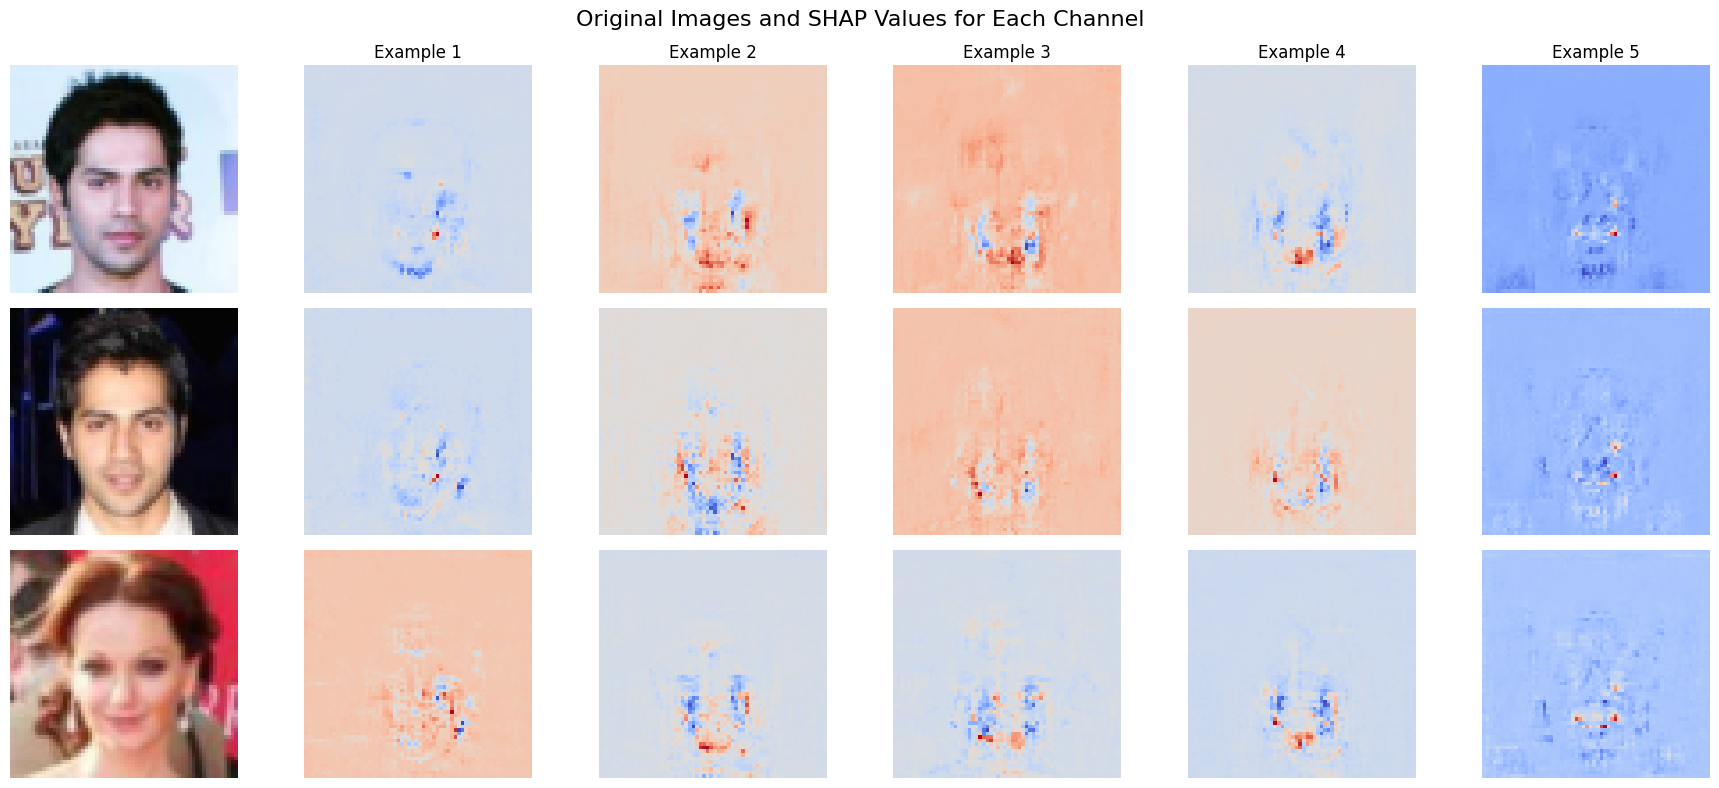

In [113]:
# SHAP değerlerinin boyutu: (5, 3, 64, 64, 1) - [5 örnek, 3 kanal (RGB), 64x64, 1]
# test_numpy'nin boyutu: (3, 64, 64, 3) - Gerçek görüntüler

shap_numpy = np.array(shap_numpy)

num_examples = shap_numpy.shape[0]  # SHAP değerlerindeki örnek sayısı (örneğin 5)
num_channels = shap_numpy.shape[1]  # Kanal sayısı (örneğin 3: RGB kanalları)

# Görseller için num_channels satır (her kanal için bir satır),
# num_examples + 1 sütun (örnekler ve en başta gerçek görüntü) olacak şekilde düzenleyelim
fig, axes = plt.subplots(num_channels, num_examples + 1, figsize=(18, 8))  # +1 sütun gerçek görüntüler için

# İlk sütuna gerçek görüntüleri ekleyelim (her kanal için)
for channel in range(num_channels):
    real_image = test_numpy[channel]  # Her kanalda farklı bir gerçek görüntü göster
    ax = axes[channel, 0]  # Kanalın ilk sütunu (sol) gerçek görüntü olacak
    ax.imshow(real_image)  # Gerçek görüntüyü ekle
    ax.axis('off')  # Eksenleri gizle

# Sol tarafta sadece birinci sütuna kanal isimleri ve başlıklar ekleyelim
for channel in range(num_channels):
    axes[channel, 0].set_ylabel(f"Channel {channel + 1}", fontsize=12, rotation=0, labelpad=40)  # Kanal isimleri

# SHAP değerlerini her kanal için ve her örnek üzerinde döngü yaparak ekleyelim
for i in range(num_examples):
    shap_image = np.squeeze(shap_numpy[i], axis=-1)  # SHAP değerlerini sıkıştır (64x64)

    for channel in range(num_channels):
        ax = axes[channel, i + 1]  # Kanal ve örneğe göre doğru ekseni al
        ax.imshow(shap_image[channel], cmap='coolwarm')  # Kanal için SHAP görselleştirmesini yap
        ax.axis('off')  # Eksenleri gizle

# Her örnek için başlıklar ekleyelim
for i in range(num_examples):
    axes[0, i + 1].set_title(f"Example {i + 1}", fontsize=12)

# Görselleri daha sıkı yerleştirelim
plt.suptitle("Original Images and SHAP Values for Each Channel", fontsize=16)
plt.tight_layout()
plt.show()
